# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from ma_ddpg import Agents
from collections import deque
import torch

#Instance of the agents
agents = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents)

In [6]:
# Hyper parameters to train the agent

n_episodes = 3000
print_every = 100  # Print when checking for socre and minimal lenght for a solved episode

mean_scores_track = []
last_mean_score = 0.                       # Keep track of last mean to save improved model

scores = []                                # list containing scores from each episode
scores_window = deque(maxlen=print_every)  # last 100 scores

flag = True # Just to get when the mean is higher than 0.5

# Here the code will run for # episodes to train the agent
for i_episode in range(1, n_episodes+1):
    
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    score = np.zeros(num_agents)
    
    agents.reset() # Noise reset
    
    while True: # Iteract with the environment until is done
        
        actions = agents.act(states) # get agents action with little noise for exploration
        
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        
        # Perform the agents step in the environment
        agents.step(states, actions, rewards, next_states, dones)
            
        states = next_states
        score += rewards
        if np.any(dones):
            break 
    
    scores_window.append(np.max(score))       # save most recent score window
    scores.append(np.max(score))              # save most recent max score to plot
    mean_scores_track.append(np.mean(scores_window)) # mean score to check on plot
    
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    # Check episode score evolution
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\t Max score: {:.2f}'.format(i_episode, np.mean(scores_window), np.max(scores_window)))
    
    mean_sc = np.mean(scores_window) # Compute the mean score over the last 100 episodes
    
    if len(scores_window) == print_every:
        if mean_sc > last_mean_score:
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            last_mean_score = mean_sc
    
    
    if len(scores_window) == print_every and mean_sc > 0.5 and flag:
        print('\rEnvironment solved in {} episodes, mean score: {:.2f}'.format(i_episode, mean_sc))
        flag = False
    
    # Lets quit training when the average is above 0.7, just to train the agent a little more
    if len(scores_window) == print_every and mean_sc > 0.7:
        break

Episode 100	Average Score: 0.01	 Max score: 0.10
Episode 200	Average Score: 0.02	 Max score: 0.10
Episode 300	Average Score: 0.02	 Max score: 0.10
Episode 400	Average Score: 0.02	 Max score: 0.20
Episode 500	Average Score: 0.05	 Max score: 0.30
Episode 600	Average Score: 0.04	 Max score: 0.10
Episode 700	Average Score: 0.07	 Max score: 0.30
Episode 800	Average Score: 0.11	 Max score: 0.40
Episode 900	Average Score: 0.14	 Max score: 0.60
Episode 1000	Average Score: 0.26	 Max score: 2.60
Episode 1100	Average Score: 0.19	 Max score: 2.00
Episode 1200	Average Score: 0.12	 Max score: 0.20
Environment solved in 1263 episodes, mean score: 0.50
Episode 1289	Average Score: 0.71

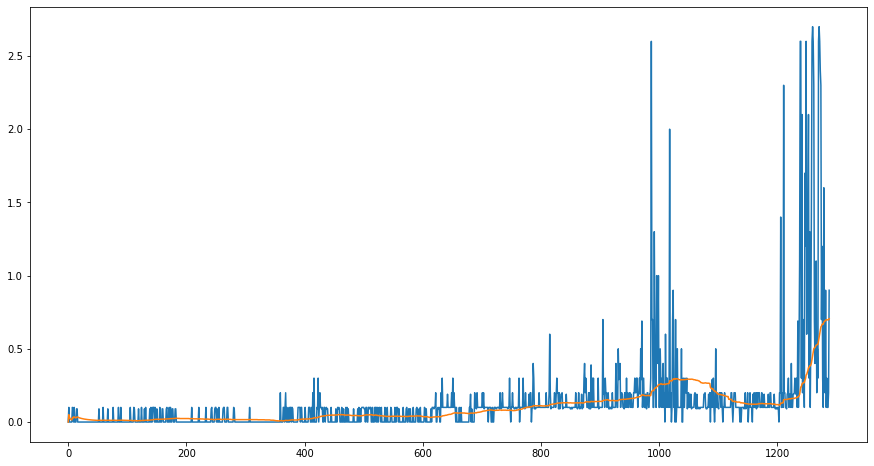

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(scores)
plt.plot(mean_scores_track)
plt.show()

# Testing the trained agent

In [6]:
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size 
state_size = env_info.vector_observations.shape[1]

agents = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents)

# load Models
actor_dict = torch.load('checkpoint_actor_best.pth')
critic_dict = torch.load('checkpoint_critic_best.pth')

agents.actor_local.load_state_dict(actor_dict)
agents.actor_target.load_state_dict(actor_dict)

agents.critic_local.load_state_dict(critic_dict)
agents.critic_target.load_state_dict(critic_dict)

<All keys matched successfully>

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agents.act(states, add_noise=False)      # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019
Score (max over agents) from episode 2: 2.7000000402331352
